<a href="https://colab.research.google.com/github/msommerfe/CAS_Applied_Data_Science/blob/main/CAS_Final_Project/OCR_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split

In [2]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/colab/keras-ocr'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Mounted at /content/drive


In [3]:
### Converting Chars to nums is better for ML

alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' 0123456789"
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels
batch_size = 128

def label_to_num(label):
    label_num = []
    for ch in label:

            label_num.append(alphabets.find(ch) if alphabets.find(ch)!=-1 else alphabets.find('-'))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret



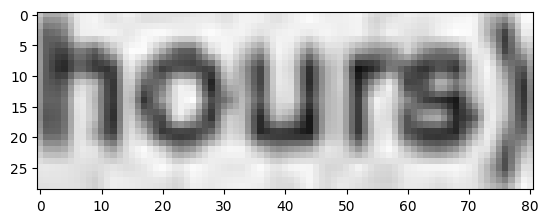

array([[195, 169, 170, ..., 222, 248, 250],
       [179, 143, 146, ..., 213, 248, 249],
       [166, 123, 127, ..., 199, 241, 241],
       ...,
       [229, 230, 229, ..., 193, 232, 228],
       [227, 228, 228, ..., 209, 242, 235],
       [225, 225, 226, ..., 222, 248, 239]], dtype=uint8)

In [5]:
ImgFolder = '/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/dataset/v011_words_small/'
imgPath = os.path.join(ImgFolder, "10.png")


plt.imshow(cv2.imread(imgPath))
plt.show()
cv2.imread(imgPath,cv2.IMREAD_GRAYSCALE)

(29, 81)


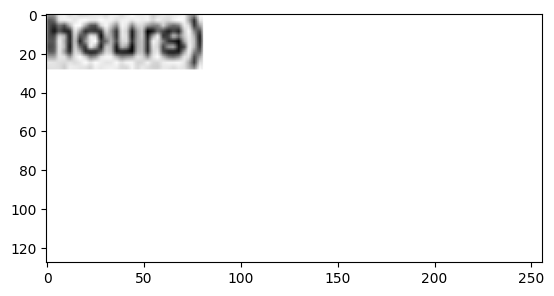

In [6]:
#Scales the width if the image to max_width. Only if the high after scaling to max_width is higher than max_hight, only the hight will be scaled down to max_hight
# Expacts gray scale Images
def preprocess(img):
    max_hight = 128
    max_width = 256

    (h, w) = img.shape


    #Scale all Images down that image width is max_width
    scaleFactor = max_width / w
    if scaleFactor < 1:
      img = cv2.resize(img, None, fx = scaleFactor, fy = scaleFactor)
      (h, w) = img.shape

    #creates blank white image with size max_hight x max_width
    final_img = np.ones([max_hight, max_width])*255 # blank white image

    # if hight is still greater than max_hight, scale only hight down to max_hight
    if h > max_hight:
       img = cv2.resize(img, None, fx = 1, fy = (max_hight/h))


    # fills the blank image with resized imput image
    final_img[:h, :w] = img
    return final_img

image = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
print(image.shape)

plt.imshow(preprocess(image),cmap='gray')

In [9]:
import json
import numpy as np
from concurrent.futures import ThreadPoolExecutor

ImgFolder = '/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/dataset/v011_words_small/'

#Reading the json {Image_filename, "test on Image"}
with open('/content/drive/MyDrive/development/datasets/OCR_MNIST_Words/v011_labels_small.json') as f:
    data = list(json.load(f).items())
keyVal = np.array(data)
y_all = keyVal[:,1]
x_all_img_path = keyVal[:,0]


def load_image(imgName):
  imgPath = ImgFolder+imgName
  entry = cv2.imread(imgPath,cv2.IMREAD_GRAYSCALE)
  print("loaded:  " + imgName)
  return preprocess(entry)



#Reading all Images and put into a np array
images = []
with ThreadPoolExecutor() as executor:
    results = executor.map(lambda path: load_image(path), x_all_img_path)
    for result in results:
        if result is not None:
            images.append(result)

x_all = np.array(images)

print(x_all.shape)
print(type(x_all))

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
loaded:  5003.jpeg
loaded:  5005.jpeg
loaded:  5006.png
loaded:  5001.png
loaded:  5008.jpeg
loaded:  5004.png
loaded:  5007.jpeg
loaded:  5009.jpeg
loaded:  5010.jpeg
loaded:  5013.jpeg
loaded:  5011.png
loaded:  5012.png
loaded:  5015.png
loaded:  5014.jpeg
loaded:  5017.jpeg
loaded:  5016.jpeg
loaded:  5020.png
loaded:  5019.jpeg
loaded:  5018.jpeg
loaded:  5021.png
loaded:  5025.jpeg
loaded:  5026.jpeg
loaded:  5022.jpeg
loaded:  5023.png
loaded:  5028.jpeg
loaded:  5031.png
loaded:  5024.jpeg
loaded:  5030.png
loaded:  5027.png
loaded:  5029.png
loaded:  5032.png
loaded:  5033.jpeg
loaded:  5036.jpeg
loaded:  5035.jpeg
loaded:  5034.png
loaded:  5038.png
loaded:  5037.jpeg
loaded:  5039.png
loaded:  5041.png
loaded:  5042.jpeg
loaded:  5045.jpeg
loaded:  5046.png
loaded:  5044.jpeg
loaded:  5040.png
loaded:  5043.png
loaded:  5050.jpeg
loaded:  5048.jpeg
loaded:  5047.jpeg
loaded:  5053.jpeg
loaded:  5054.jpeg
load

different


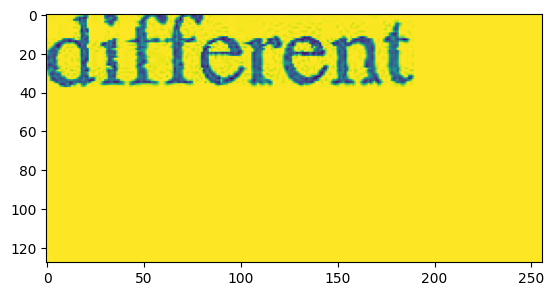

In [16]:
print(y_all[561])
plt.imshow(x_all[561])
plt.show()

In [13]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=42)

we


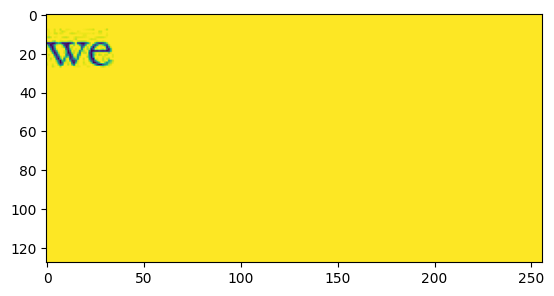

In [17]:
print(y_train[561])
plt.imshow(x_train[561])
plt.show()